In [1]:
import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from itertools import combinations
from scipy import stats
from sklearn import decomposition, preprocessing, manifold
from collections import defaultdict
from annoy import AnnoyIndex
from datetime import datetime as dt

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ab-wc5.json/'))))

955500it [00:02, 407616.85it/s]


In [4]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [5]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [6]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:19<00:00,  5.48it/s]


In [7]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'p', 'r'))

In [8]:
tick_labels = [
    dt.fromtimestamp(ts).strftime('%-m/%Y')
    for ts in np.linspace(1483228802, 1537207799, 10, dtype='int')
]

In [9]:
tick_locs = np.linspace(0, len(df.window.unique()), len(tick_labels), dtype='int')

In [10]:
def plot_pairs(lr_df, path, w=8, h=30):

    fig, axes = plt.subplots(len(lr_df), 1, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes[i]
        pdf = df[(df.d1==r.d1)&(df.d2==r.d2)].sort_values('window')

        fitx = np.array([pdf.window.min(), pdf.window.max()])
        fity = r.slope * fitx + r.intercept

        sns.boxplot(x='window', y='acc', data=pdf, ax=ax)
        ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)

        title = f'{r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('Accuracy')

    plt.tight_layout(h_pad=2)
    plt.savefig(path)
    plt.show()

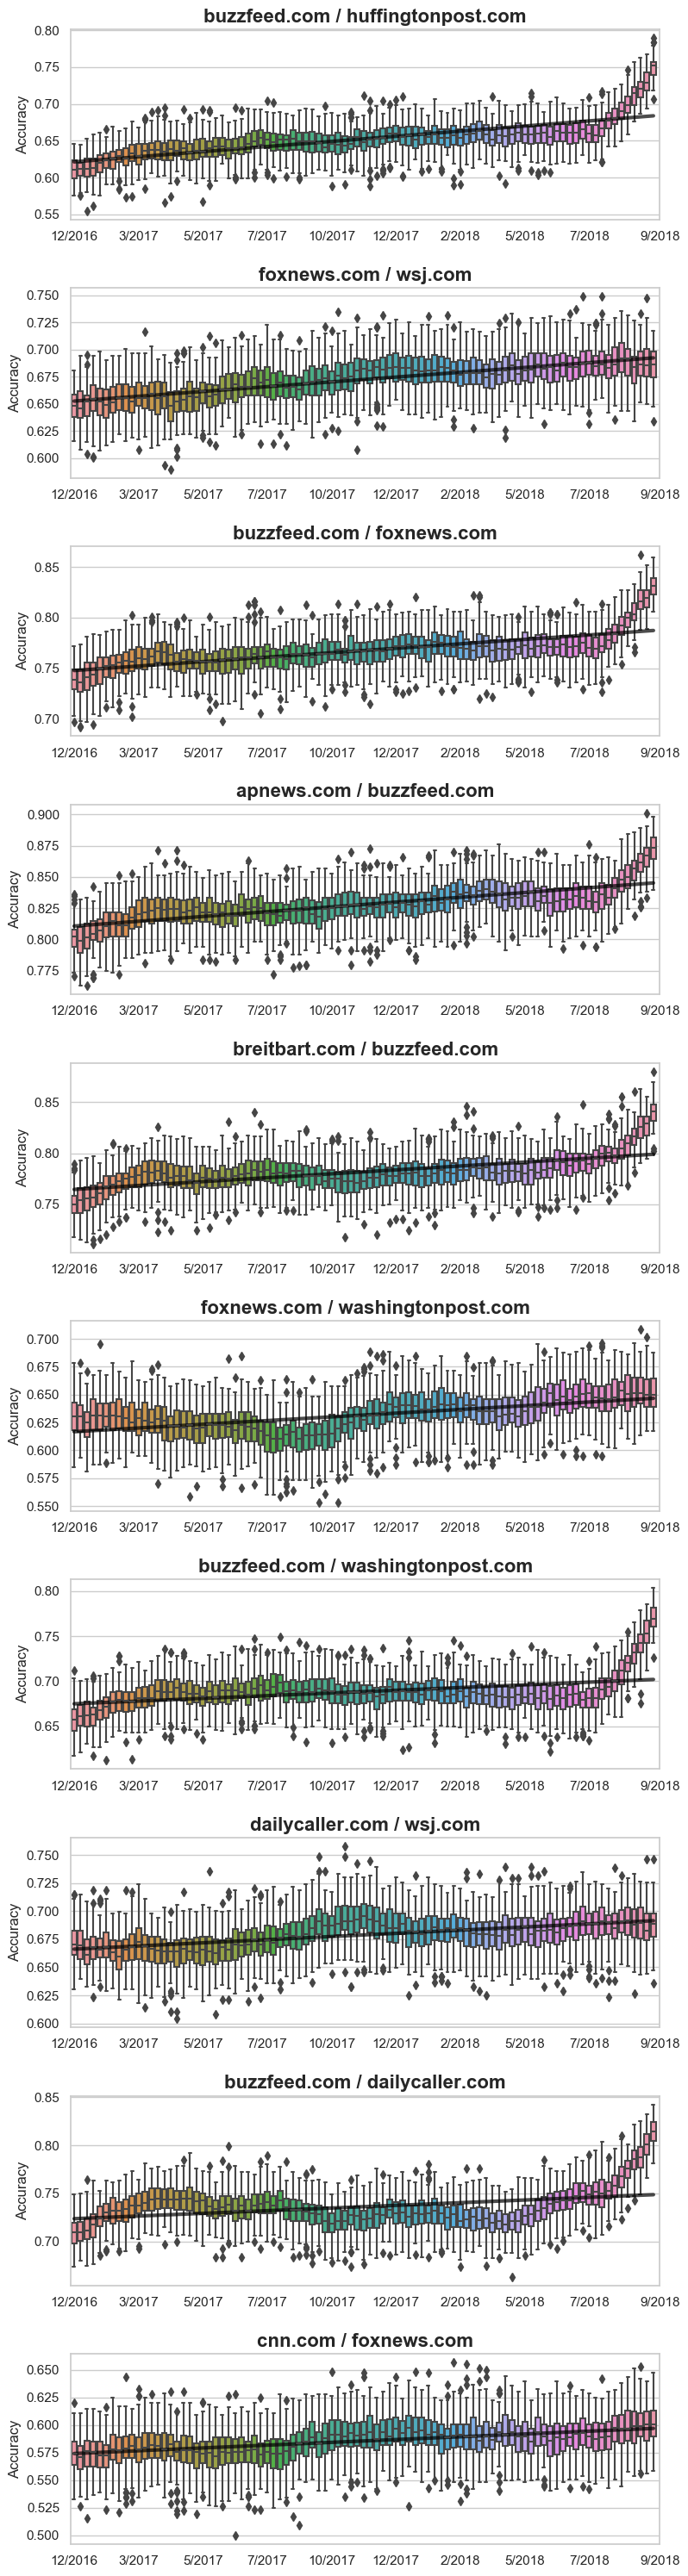

In [11]:
plot_pairs(lr_df.sort_values('slope', ascending=False).head(10), 'figures/ts-ab-rising.png')

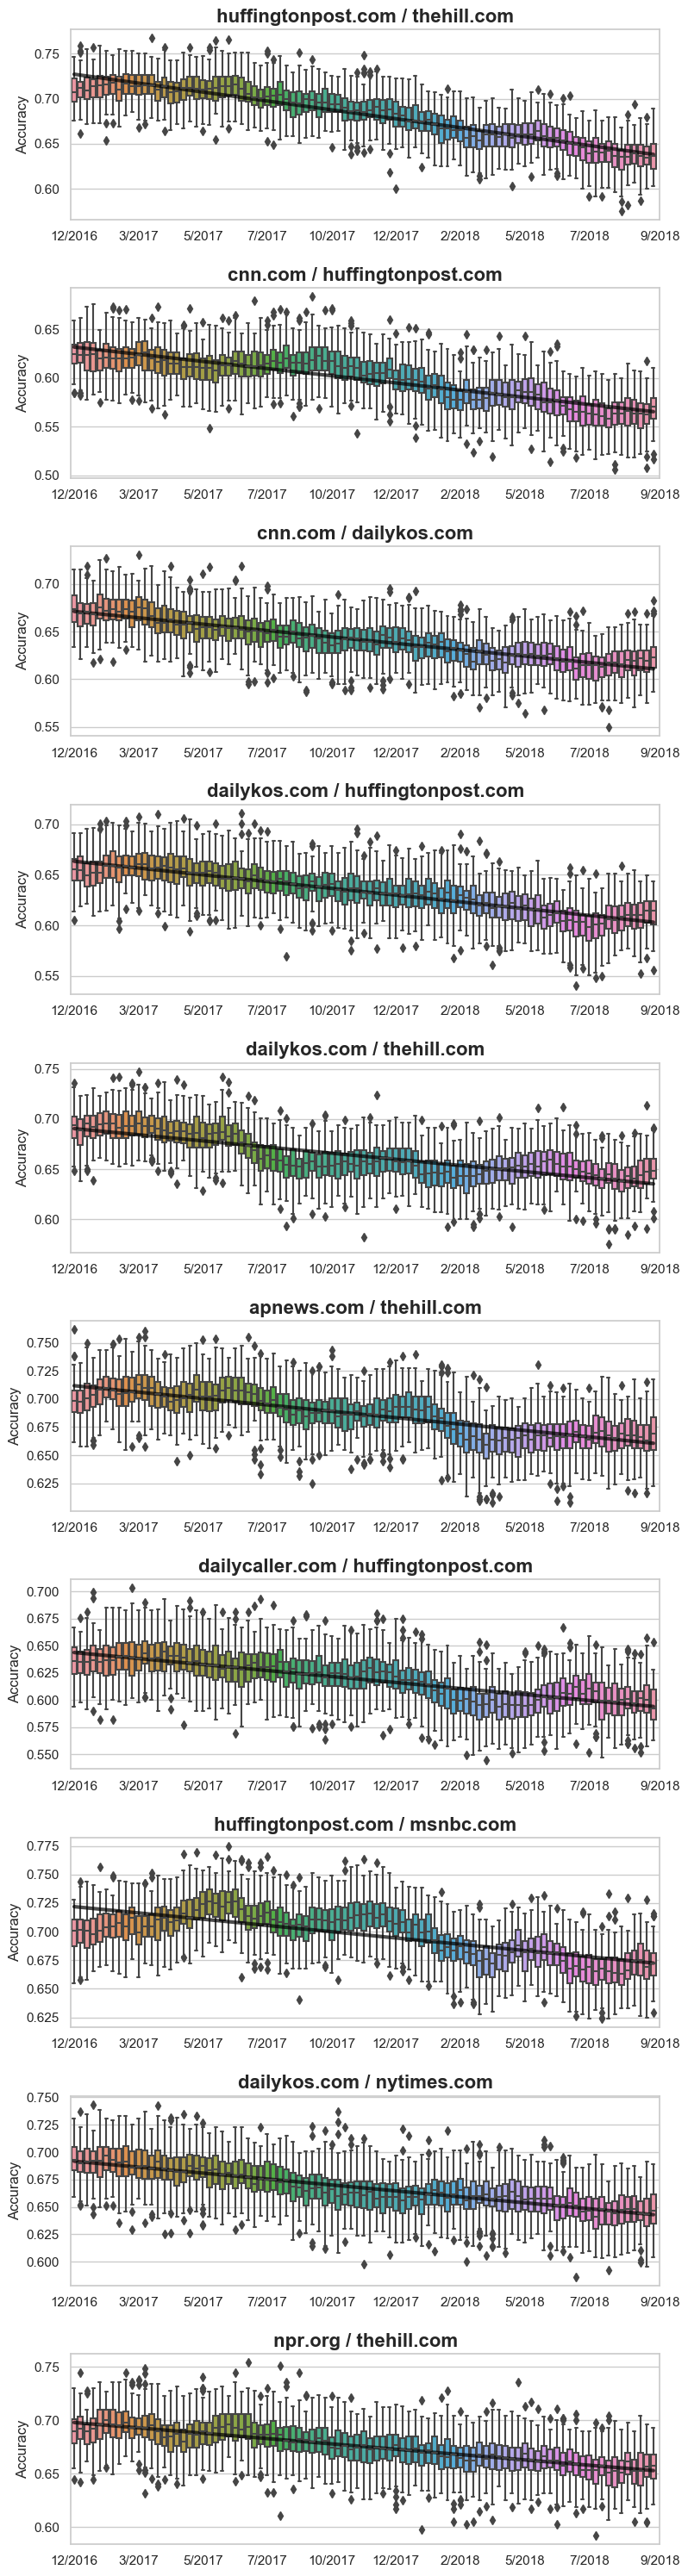

In [12]:
plot_pairs(lr_df.sort_values('slope', ascending=True).head(10), 'figures/ts-ab-falling.png')

In [13]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

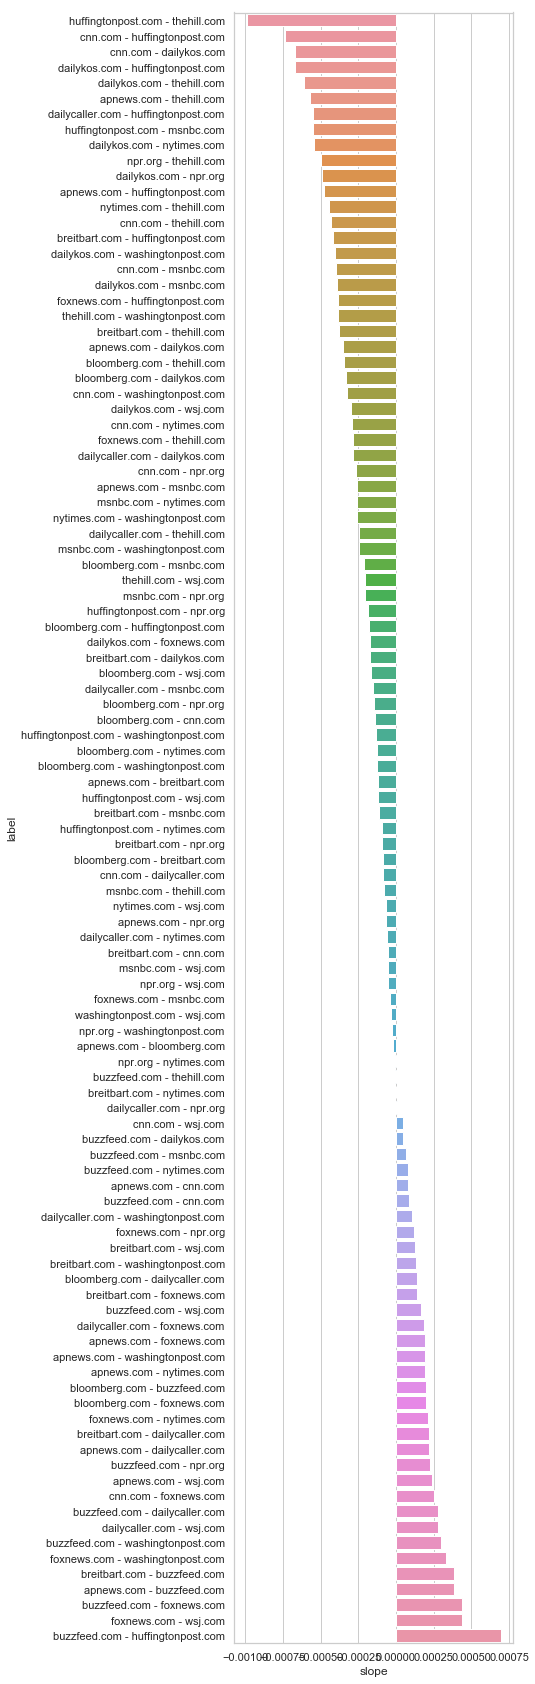

In [14]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [15]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s > 0 else 'blue')
lr_df['width'] = abs(lr_df.slope*3000)**2

In [16]:
g = nx.Graph()
for r in lr_df.sort_values('slope').itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [17]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


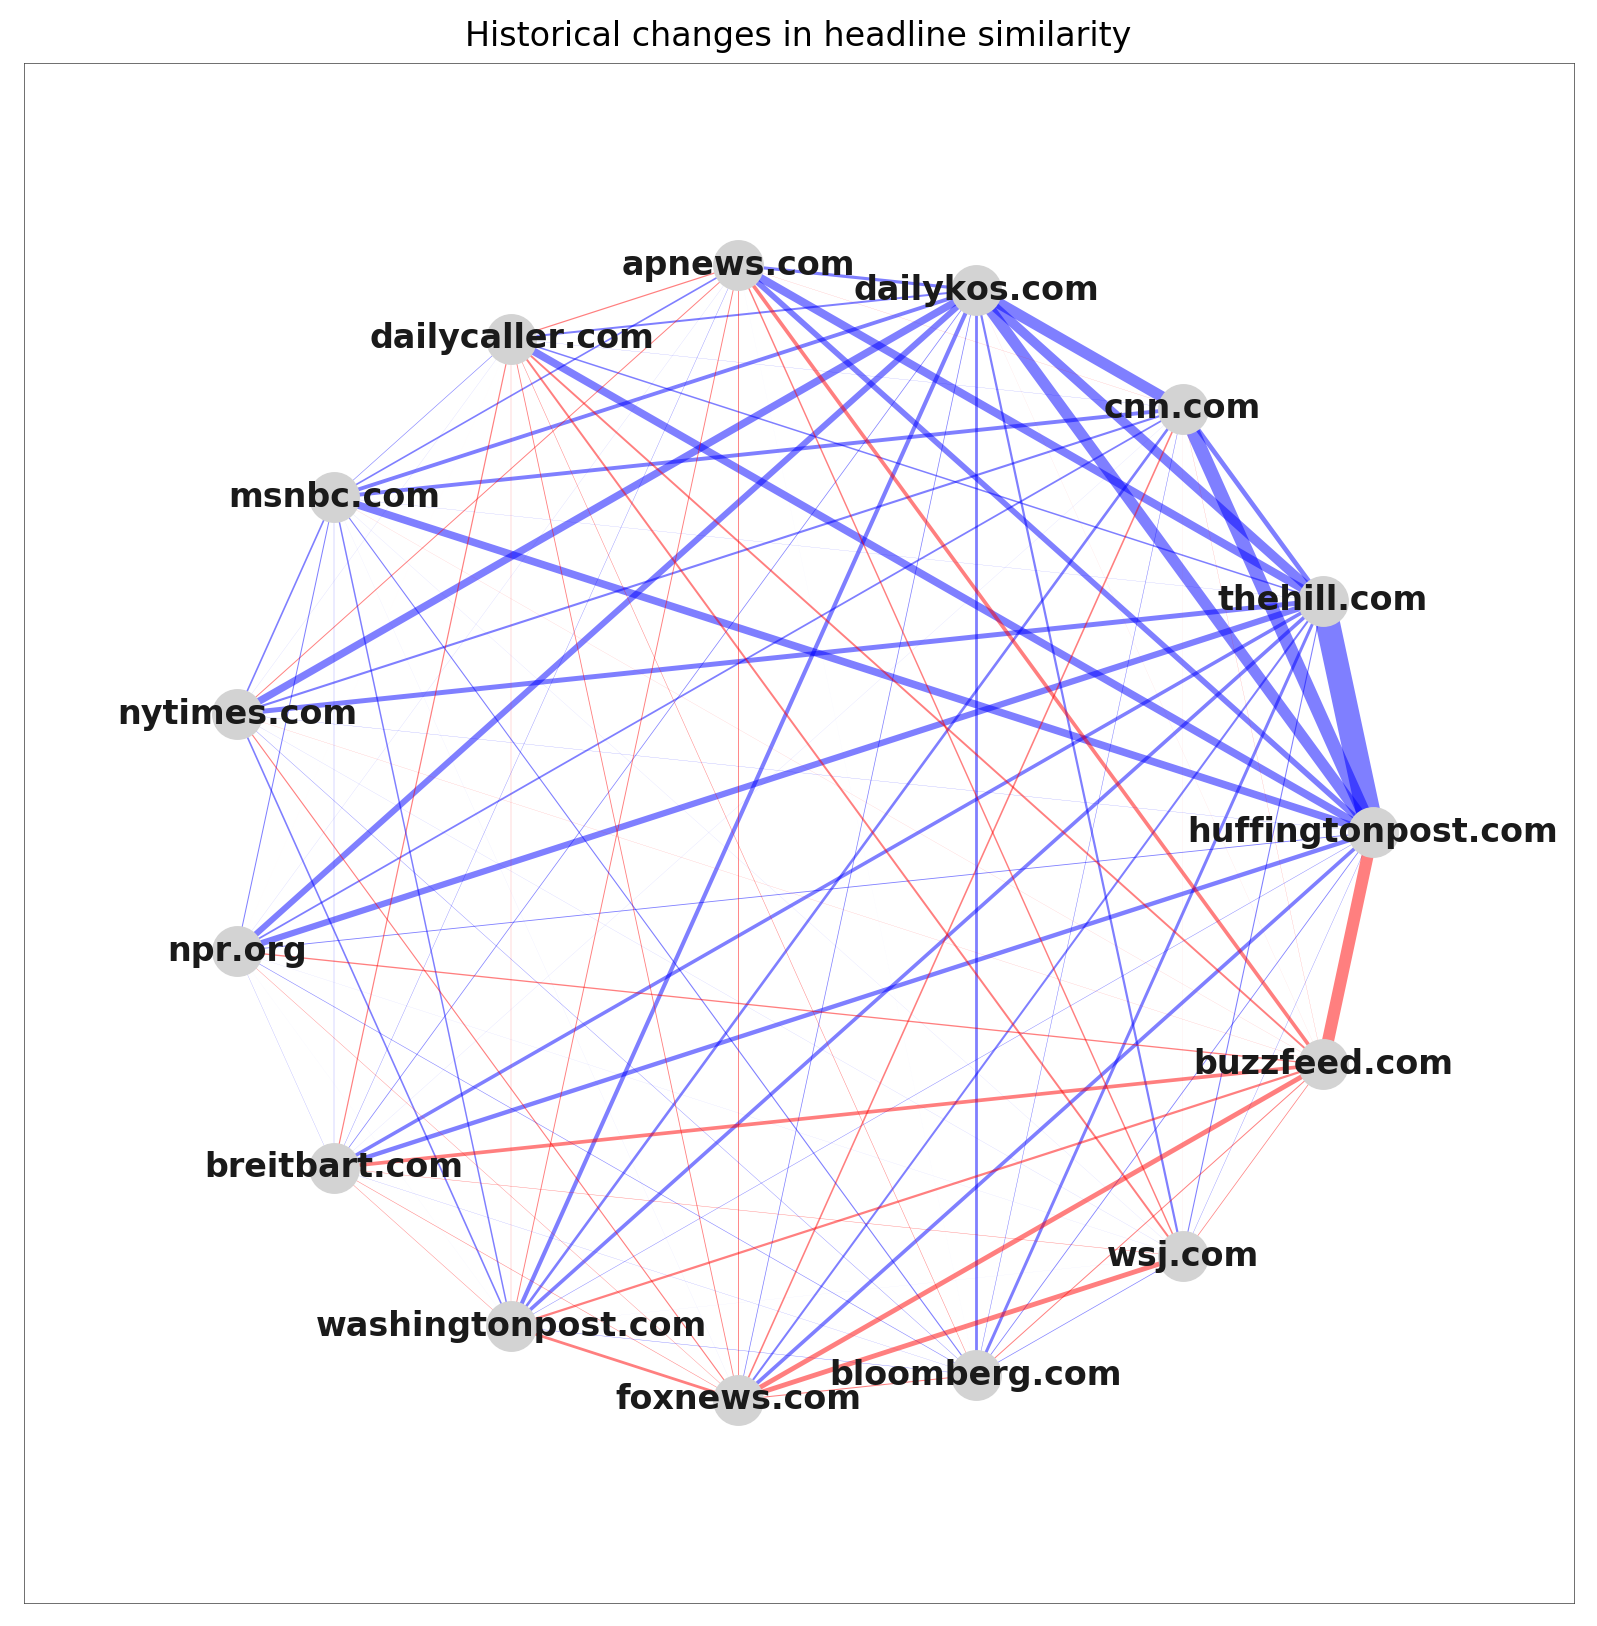

In [18]:
mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')
# plt.axis('off')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial.png', bbox_inches='tight')

In [544]:
pred_df, embeds = read_preds('../../data/ava-lstm-attn/')

100%|██████████| 283/283 [00:13<00:00, 21.09it/s]


In [552]:
pred_df_start = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) < 10))]
pred_df_end = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) > 80))]

In [558]:
idx = AnnoyIndex(embeds.shape[1])

for i in pred_df_start.index:
    idx.add_item(i, embeds[i])
    
for i in pred_df_end.index:
    idx.add_item(i, embeds[i])

In [559]:
idx.build(20)

True

In [639]:
def delta_hls(df1, df2, domain=None, n=20, probe=10000):
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)

    matches = 0
    for i in idx.get_nns_by_vector(v2-v1, probe):
        
        r = pred_df.iloc[i]
        
        if not domain or r.domain == domain:
            print('%s --- %s (%d)' % (' '.join(r.clf_tokens), r.domain, r.window))
            matches += 1
            if matches == n:
                break

# Buzzfeed

In [640]:
delta_hls(
    pred_df_start[pred_df_start.domain=='buzzfeed.com'],
    pred_df_end[pred_df_end.domain=='buzzfeed.com'],
    'buzzfeed.com',
)

answer these yes or no questions and we ll tell you which disney princess you are --- buzzfeed.com (89)
answer these # questions and we ll tell you which mcdonald s menu item you are --- buzzfeed.com (79)
go shopping at brandy melville and we ll reveal which mamma mia # character you are --- buzzfeed.com (87)
pick some snacks and we ll guess how stoned you are --- buzzfeed.com (8)
dress head to toe in urban outfitters and we ll reveal which riverdale character you are --- buzzfeed.com (83)
pick some colored shirts and we ll reveal which the breakfast club character you re most like --- buzzfeed.com (88)
order an ice cream sundae and we ll tell you which arthur character you are --- buzzfeed.com (82)
choose some food combos and we ll reveal which iconic duo you and your bff are --- buzzfeed.com (87)
go shopping at lush and we ll tell you which celeb you ll have a summer fling with --- buzzfeed.com (82)
spend all your money at topshop and we ll reveal which game of thrones character you 

In [641]:
delta_hls(
    pred_df_end[pred_df_end.domain=='buzzfeed.com'],
    pred_df_start[pred_df_start.domain=='buzzfeed.com'],
    'buzzfeed.com',
)

koch network focuses on understanding trump voters --- buzzfeed.com (2)
republicans walk away from january # target to repeal obamacare --- buzzfeed.com (0)
company tied to trump campaign once pushed for voter suppression --- buzzfeed.com (1)
we must learn to gently push hard --- buzzfeed.com (89)
china calls on trump and north korea to show restraint --- buzzfeed.com (83)
seven things to watch for when trump meets putin next week --- buzzfeed.com (83)
kamala harris endorses stacey abrams for georgia governor --- buzzfeed.com (74)
they are children not hostages --- buzzfeed.com (82)
do nt forget the dots --- buzzfeed.com (0)
whatever happened to us advocates of regime change in north korea --- buzzfeed.com (82)
manafort under scrutiny for $ # million in suspicious transactions --- buzzfeed.com (65)
ivanka s social media and the aesthetics of denial --- buzzfeed.com (5)
native nations brought the standing rock fight to washington --- buzzfeed.com (8)
we may never know what happened in t

# Fox

In [642]:
delta_hls(
    pred_df_start[pred_df_start.domain=='foxnews.com'],
    pred_df_end[pred_df_end.domain=='foxnews.com'],
    'foxnews.com'
)

nervous dog escapes crate forces emergency landing by tearing inner lining of luggage compartment --- foxnews.com (85)
four missouri children locked in boxes secured with plywood and screws cops say # arrested --- foxnews.com (87)
brett kavanaugh vows to keep an open mind in every case after chaotic confirmation hearing day --- foxnews.com (90)
california sikh man heinously attacked while placing road signs for gop congressman police say --- foxnews.com (87)
queen of clean comedian chonda pierce stands up against backlash over her trump inauguration gig --- foxnews.com (2)
tennessee teacher s petty note restricting bathroom and nurse breaks goes viral sparks outrage --- foxnews.com (89)
brave americans coming home as north korea hands over remains roseanne says she s not a racist --- foxnews.com (89)
carol burnett star tim conway recovers from brain surgery as family battle over comic s fate rages on --- foxnews.com (90)
wwe legend jerry lawler s son reportedly on life support after at

In [643]:
delta_hls(
    pred_df_end[pred_df_end.domain=='foxnews.com'],
    pred_df_start[pred_df_start.domain=='foxnews.com'],
    'foxnews.com'
)

teaching young americans about money --- foxnews.com (4)
woodward book under attack --- foxnews.com (90)
trump says he wo nt label china a currency manipulator --- foxnews.com (11)
trump says he ll bargain to lower prescription drug costs --- foxnews.com (6)
penn state abuse scandal costs approach a quarter billion --- foxnews.com (1)
small business owner salutes trump push to slash regulations --- foxnews.com (4)
dealing with facebook blowhards --- foxnews.com (3)
after years as an outcast mel gibson earns an oscar nomination --- foxnews.com (3)
starbucks straw ban questioned by disability rights groups --- foxnews.com (87)
the master of ceremonies plays on --- foxnews.com (81)
some play the odds on health care over costs --- foxnews.com (82)
scientists invent way to create unlimited renewable energy --- foxnews.com (90)
in kentucky coal country a potential embrace of nuclear power --- foxnews.com (11)
zuckerberg outlines facebook s strategy to fight election meddling --- foxnews.com 

# DailyKos <-> HuffPo <-> Hill

In [647]:
delta_hls(
    pred_df_start[pred_df_start.domain=='thehill.com'],
    pred_df_end[pred_df_end.domain.apply(lambda d: d in ('dailykos.com', 'huffingtonpost.com', 'thehill.com'))],
    'thehill.com'
)

trump s new supreme court justice could weigh death penalty dispute in first days on the job --- thehill.com (79)
the only way to get truly universal care is to throw people in jail if they do nt have it --- thehill.com (10)
can we stop the gun violence epidemic yes by treating it as a health crisis --- thehill.com (83)
ice raids a dozen businesses in nebraska and minnesota in vast tax fraud investigation --- thehill.com (85)
trump says calling mexican immigrants rapists was peanuts in comparison to the truth --- thehill.com (86)
blue state republicans say they will vote against tax cuts # if it extends salt cap --- thehill.com (90)
tom perez embodies the democratic party this is why he should lead it --- thehill.com (5)
trump tariffs are an affront to canadian soldiers who fought and died alongside americans --- thehill.com (75)
trump told kim kardashian she and kanye west are boosting his approval with black voters --- thehill.com (77)
inflatable trump chicken dressed like a prisoner

In [648]:
delta_hls(
    pred_df_start[pred_df_start.domain=='dailykos.com'],
    pred_df_end[pred_df_end.domain.apply(lambda d: d in ('dailykos.com', 'huffingtonpost.com', 'thehill.com'))],
    'dailykos.com'
)

trump says he does nt need to prepare for north korea summit --- dailykos.com (83)
syrians knew of attack moved personnel critical targets --- dailykos.com (14)
trump hhs pick tom price confirmed in party line vote --- dailykos.com (5)
south carolina plant announces closure cites trump tariffs --- dailykos.com (87)
tariffs cause bmw to move production out of south carolina --- dailykos.com (86)
miami state senator under fire for calling colleagues --- dailykos.com (15)
pennsylvania man speaks out files lawsuit against police --- dailykos.com (86)
tillerson changes tune says assad has no role in governing syria --- dailykos.com (15)
us strikes syrian air base with dozens of cruise missiles --- dailykos.com (9)
trump campaign rally in melbourne fla begins soon --- dailykos.com (5)
rhino poachers eaten by lions on game reserve in south africa --- dailykos.com (81)
camp changed strategy after russians stole dnc analytics --- dailykos.com (82)
ozone eating chemical makers revealed arms race

In [649]:
delta_hls(
    pred_df_start[pred_df_start.domain=='huffingtonpost.com'],
    pred_df_end[pred_df_end.domain.apply(lambda d: d in ('dailykos.com', 'huffingtonpost.com', 'thehill.com'))],
    'huffingtonpost.com'
)

dark money group leading kavanaugh confirmation was not authorized to operate in dc --- huffingtonpost.com (90)
sessions was # percent straight with senate committee --- huffingtonpost.com (8)
sessions to recuse himself from russia investigations --- huffingtonpost.com (6)
ice agents arrest dream er without criminal record --- huffingtonpost.com (4)
do nt count on susan collins to save roe v wade --- huffingtonpost.com (90)
it s time to talk about impeachment --- huffingtonpost.com (9)
house healthcare bill is mortally wounded --- huffingtonpost.com (9)
republicans complain privately about trump all the time --- huffingtonpost.com (2)
mcconnell goes nuclear to break supreme court filibuster --- huffingtonpost.com (9)
cbo predicts # million uninsured higher premiums in first year after obamacare repeal and delay --- huffingtonpost.com (2)
flynn having frequent contacts with russian ambassador --- huffingtonpost.com (2)
state department spent $ # on curtains for nikki haley --- huffingto

In [650]:
delta_hls(
    pred_df_end[pred_df_end.domain.apply(lambda d: d in ('dailykos.com', 'huffingtonpost.com', 'thehill.com'))],
    pred_df_start[pred_df_start.domain=='huffingtonpost.com'],
    'huffingtonpost.com'
)

what you need to know about the genetics of mental disorders --- huffingtonpost.com (1)
ibm just made an awesomely queer friendly move --- huffingtonpost.com (0)
what high functioning anxiety really feels like --- huffingtonpost.com (0)
# things therapists do when they want to feel happier --- huffingtonpost.com (90)
# brides who will open your eyes to open back wedding dresses --- huffingtonpost.com (3)
# fruits and vegetables that may not be worth buying organic --- huffingtonpost.com (10)
# moves that make you feel # years younger --- huffingtonpost.com (4)
# comics you need to see if you re dealing with anxiety --- huffingtonpost.com (2)
what can you do with a creative writing degree --- huffingtonpost.com (1)
the true story of how april # became weed day --- huffingtonpost.com (66)
# times technology made the world a better place --- huffingtonpost.com (18)
# ways universities can take the lead on diversity --- huffingtonpost.com (79)
these tv couples would never survive in real l